In [35]:
# Load the libraries Needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# graph settings
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

### 1. Data Exploration: 

####  Dataset Columns

- `Customer ID`: A unique identifier for each customer
- `Surname`: The customer's surname or last name
- `Credit Score`: A numerical value representing the customer's credit score
- `Geography`: The country where the customer resides (France, Spain or Germany)
- `Gender`: The customer's gender (Male or Female)
- `Age`: The customer's age.
- `Tenure`: The number of years the customer has been with the bank
- `Balance`: The customer's account balance
- `NumOfProducts`: The number of bank products the customer uses (e.g., savings account, credit card)
- `HasCrCard`: Whether the customer has a credit card (1 = yes, 0 = no)
- `IsActiveMember`: Whether the customer is an active member (1 = yes, 0 = no)
- `EstimatedSalary`: The estimated salary of the customer
- `Exited`: Whether the customer has churned (1 = yes, 0 = no)

In [3]:
original_data = pd.read_csv('/Users/adamrivardwalter/Data for Processing/Preprocessing/Classification/Bank Churn Rate/Churn_Modelling.csv', index_col=False)
original_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
styled = original_data.describe().T.style \
    .format(precision=4) \
    .background_gradient()
styled

,count,mean,std,min,25%,50%,75%,max
RowNumber,10002.0000,5001.4996,2887.4723,1.0000,2501.2500,5001.5000,7501.7500,10000.0000
CustomerId,10002.0000,15690933.4501,71931.7693,15565701.0000,15628524.7500,15690732.0000,15753225.5000,15815690.0000
CreditScore,10002.0000,650.5551,96.6616,350.0000,584.0000,652.0000,718.0000,850.0000
Age,10001.0000,38.9223,10.4872,18.0000,32.0000,37.0000,44.0000,92.0000
Tenure,10002.0000,5.0125,2.8920,0.0000,3.0000,5.0000,7.0000,10.0000
Balance,10002.0000,76491.1129,62393.4741,0.0000,0.0000,97198.5400,127647.8400,250898.0900
NumOfProducts,10002.0000,1.5302,0.5816,1.0000,1.0000,1.0000,2.0000,4.0000
HasCrCard,10001.0000,0.7055,0.4558,0.0000,0.0000,1.0000,1.0000,1.0000
IsActiveMember,10001.0000,0.5149,0.4998,0.0000,0.0000,1.0000,1.0000,1.0000
EstimatedSalary,10002.0000,100083.3311,57508.1178,11.5800,50983.7500,100185.2400,149383.6525,199992.4800


In [6]:
# The original dataset was already split into 2 CSV files (Train.csv and Test.csv)

training_data = original_data.sample(frac=0.8, random_state=42)
testing_data = original_data.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing data examples: {testing_data.shape[0]}")

No. of training examples: 8002
No. of testing data examples: 2000


In [7]:
training_data.reset_index(inplace=True)
testing_data.reset_index(inplace=True)

### 2. Exploritory Data Analysis (EDA)

### 2.1 Null Values:
Missing data/Null values is defined as the values or data that is not stored (or not present) for some variable/s in the given dataset.Here is a list of popular strategies to handle missing values in a dataset

- Deleting the Missing Values
- Imputing the Missing Values
- Imputing the Missing Values for Categorical Features
- Imputing the Missing Values using Sci-kit Learn Library
- Using “Missingness” as a Feature
- 
Let's see if our data has any missing values or not.

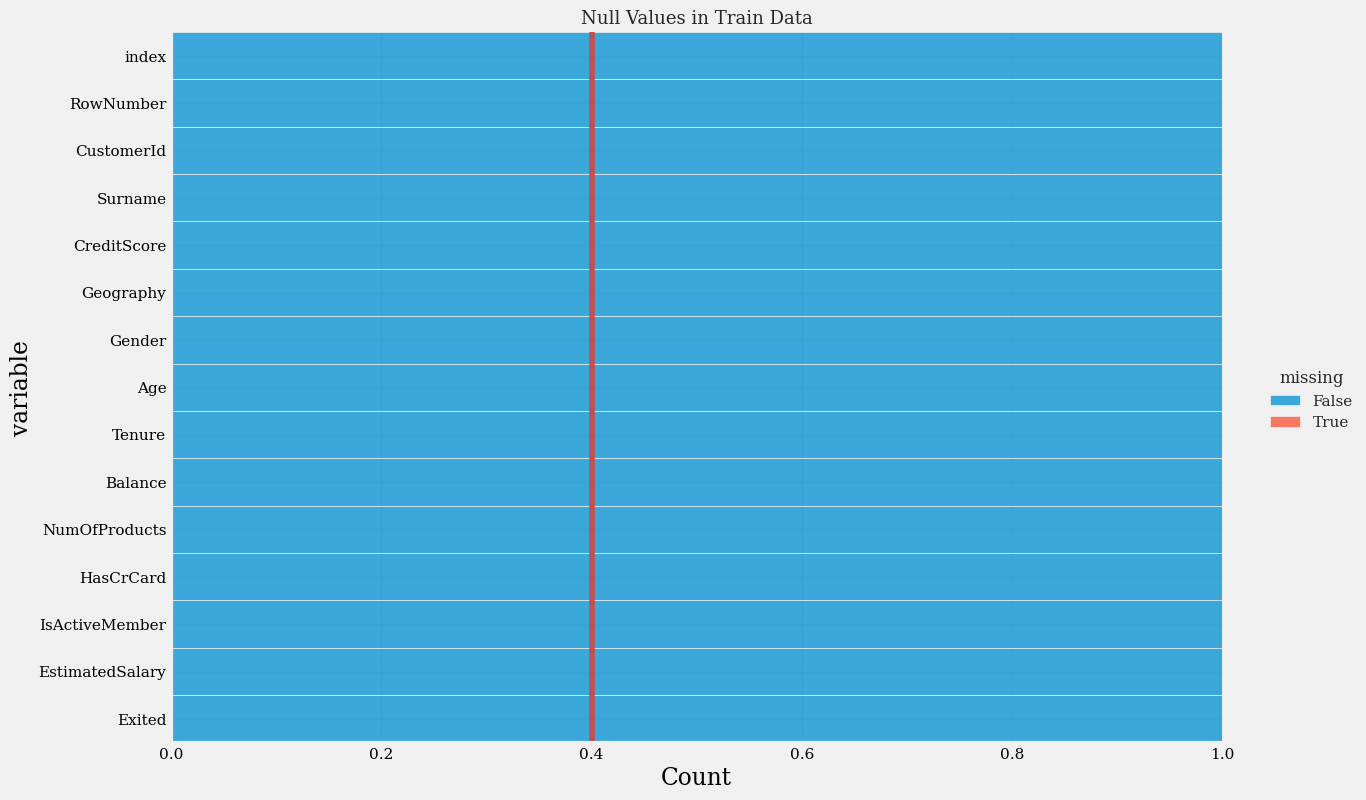

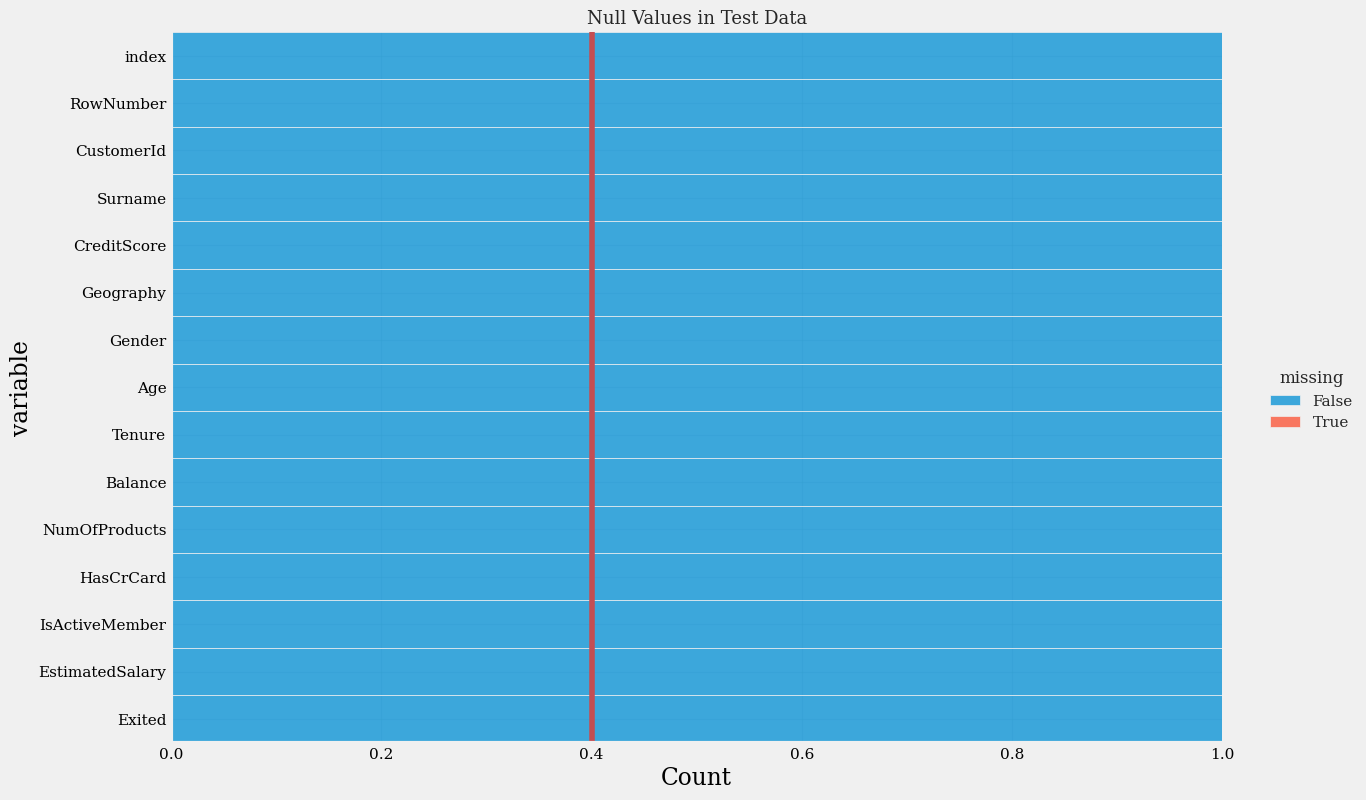

In [8]:
# We could just use the 'original_data', but the original data was from 2 files (train.csv and test.csv)
sns.displot(data=training_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Train Data', fontsize=13)
plt.show()

#----------------------------


sns.displot(data=testing_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Test Data', fontsize=13)
plt.show()

### 2.2 Target Variable Analysis

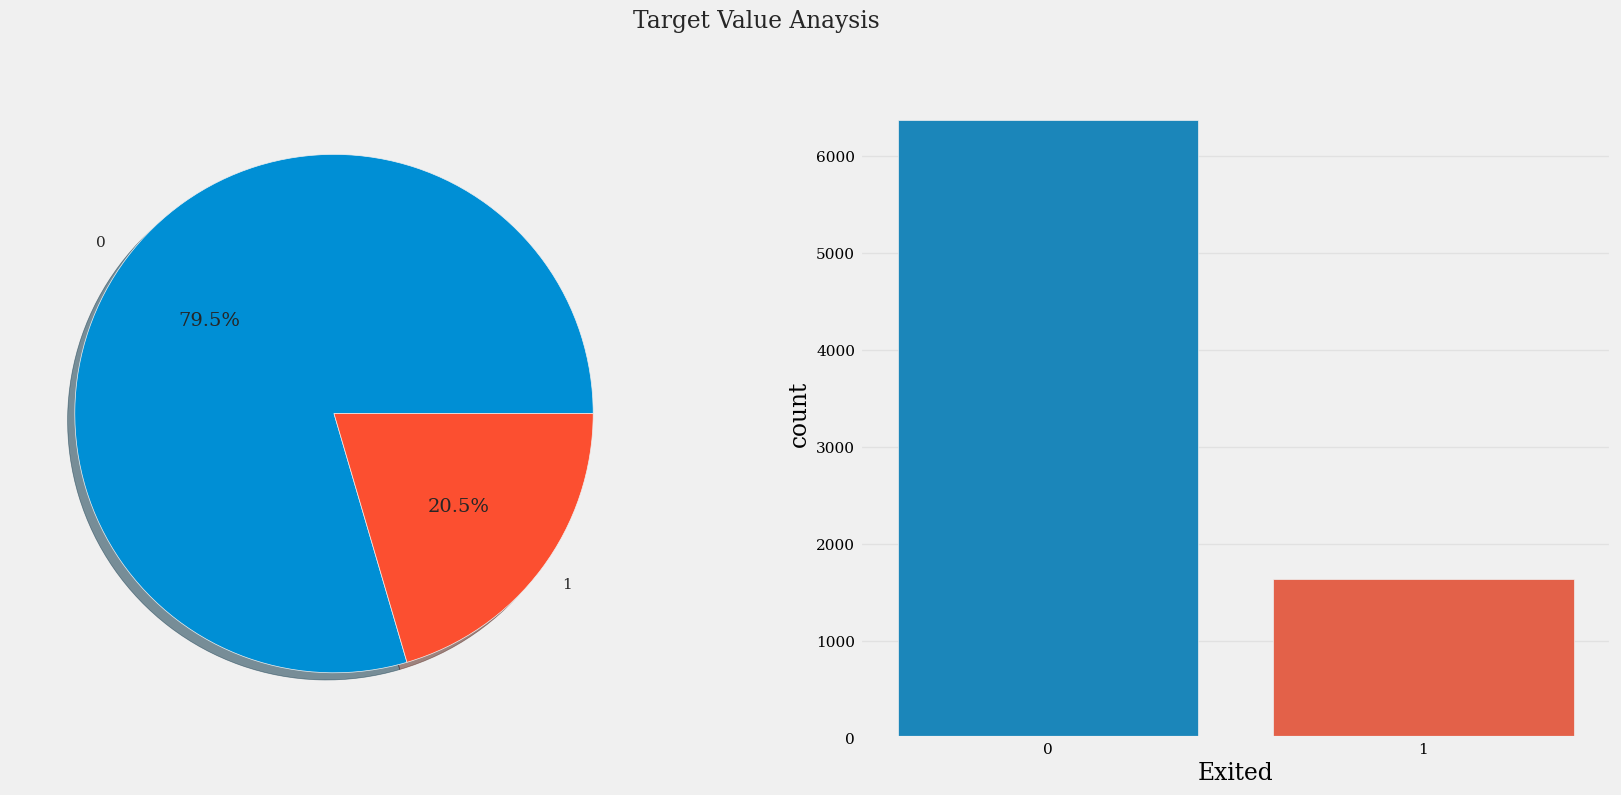

In [11]:

f,ax=plt.subplots(1,2,figsize=(19,8))
training_data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
# ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')
sns.countplot(x='Exited',data=training_data,ax=ax[1])
# ax[1].set_title('Count-Plot')
plt.suptitle('Target Value Anaysis')
plt.show()


### Some Observations from above plots:

- We can see that data is highly imbalanced. Almost 80% of our data is from class 0 (not exited) and 20% data is from class 1 (exited).
- In a real life also we only care about the persons or the people who are quitting or leaving (Exited) the bank and we only want to analyse the patterns of those people.

### 2.3 Categorical Variables Analysis:

Our categorical varibles are:

- Geography
- Gender
- Tenure
- NumOfProducts
- HasCrCard
- IsActiveMember

In [12]:
unique_counts = training_data.nunique()

# Threshold to distinguish continuous and categorical
threshold = 12

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

print(f"Categorical Variables: {categorical_vars}")
print(f"\nContinousl/Numerical Variables: {continuous_vars}")

Categorical Variables: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

Continousl/Numerical Variables: ['index', 'RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']


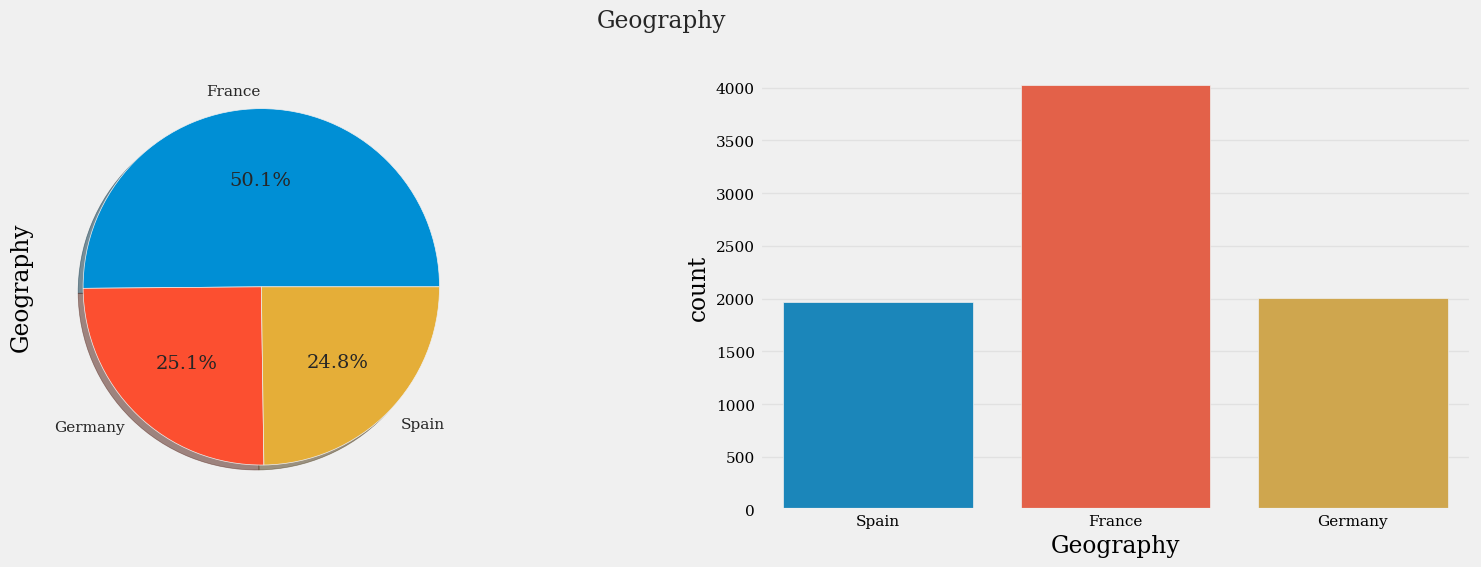

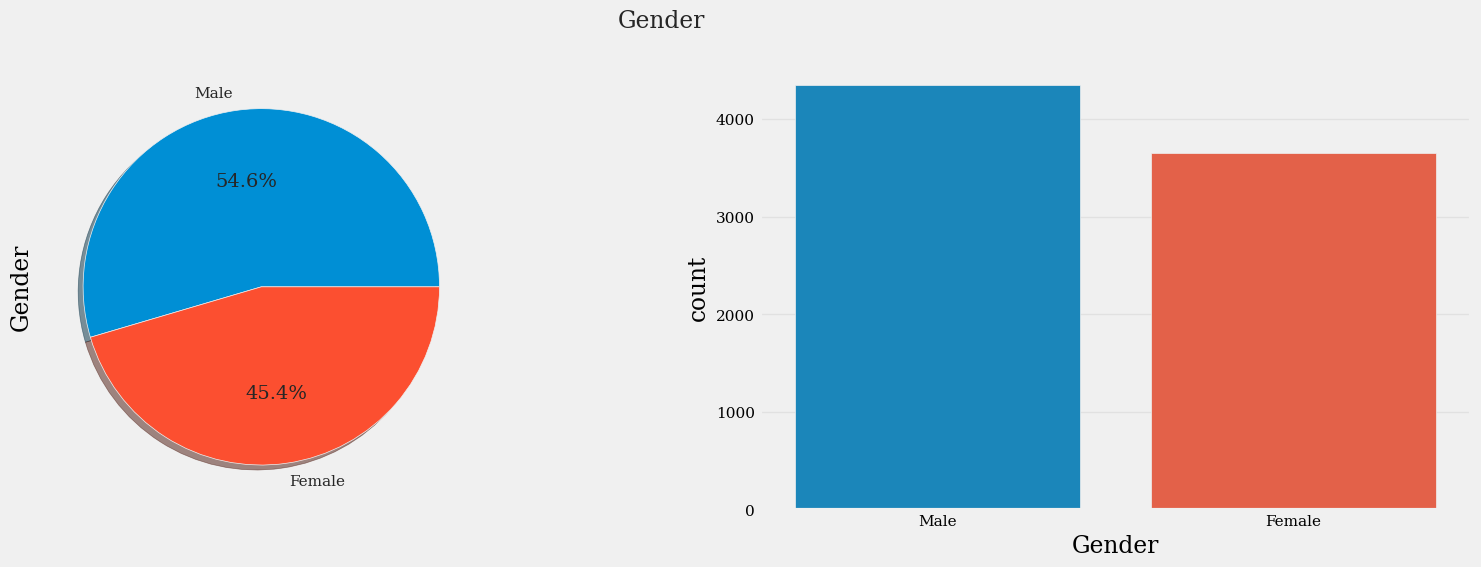

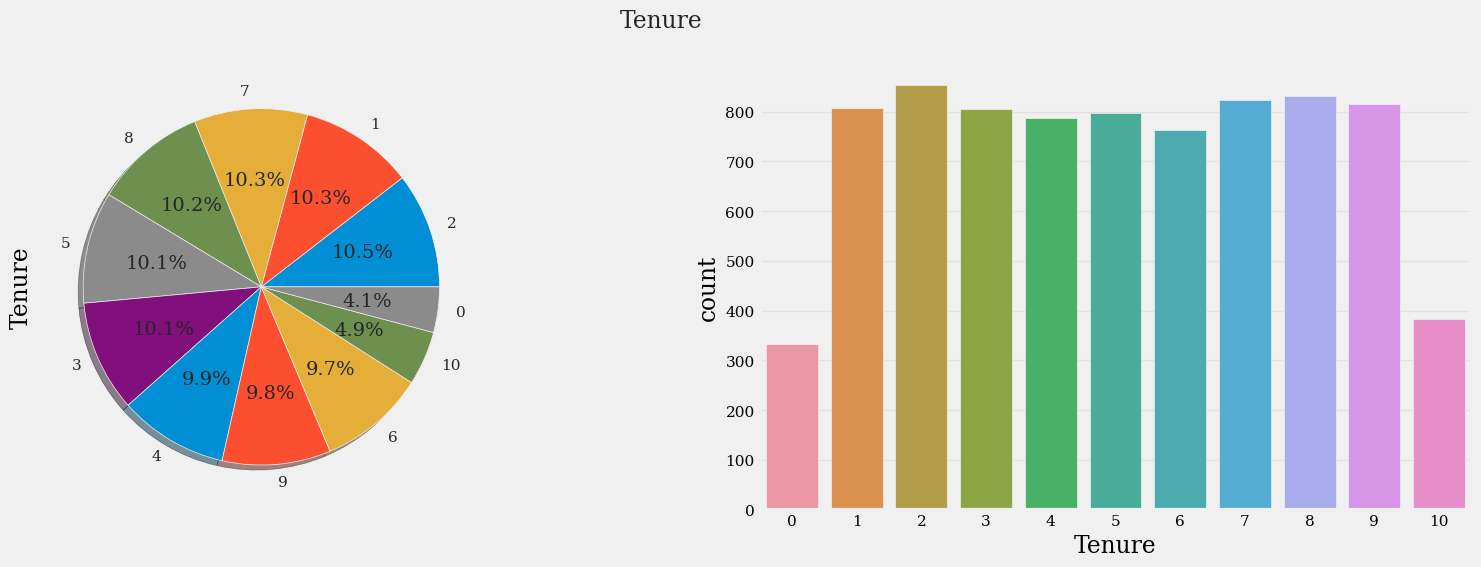

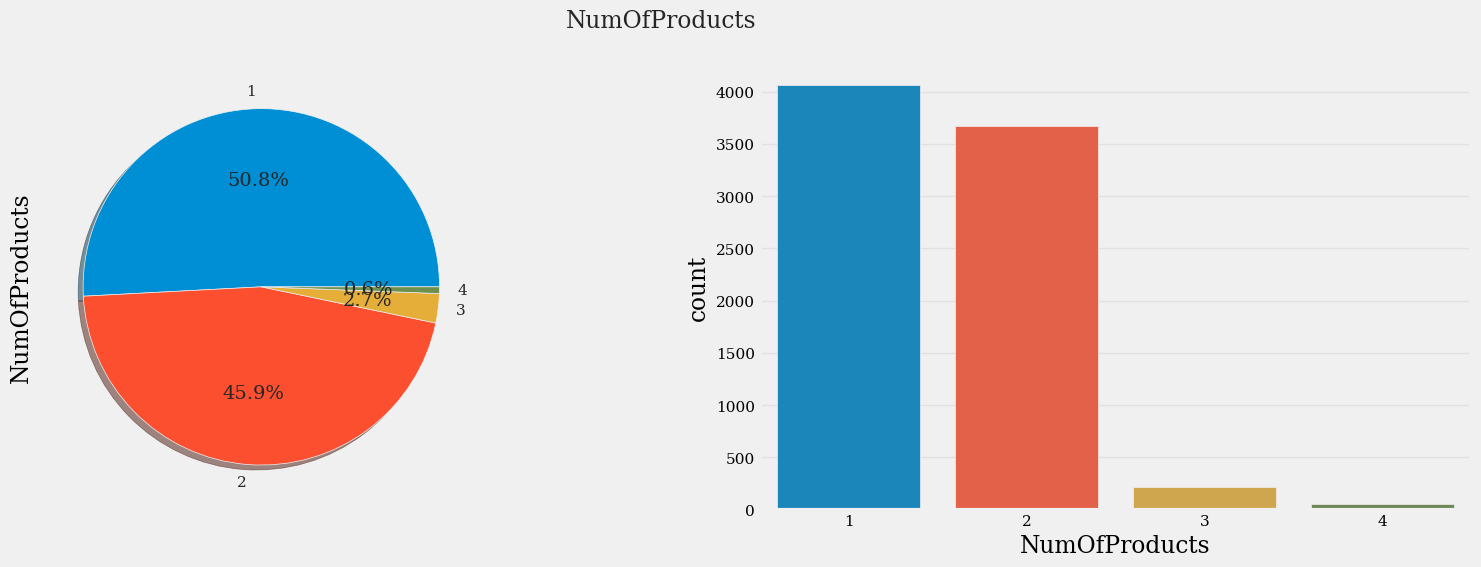

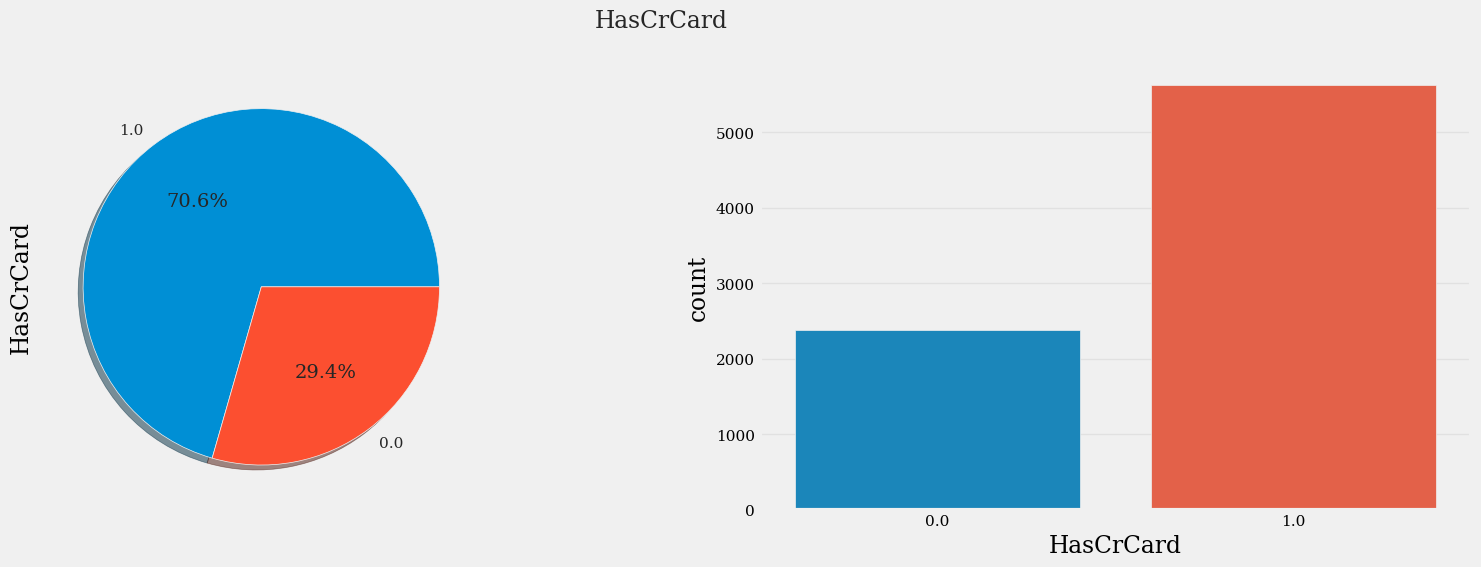

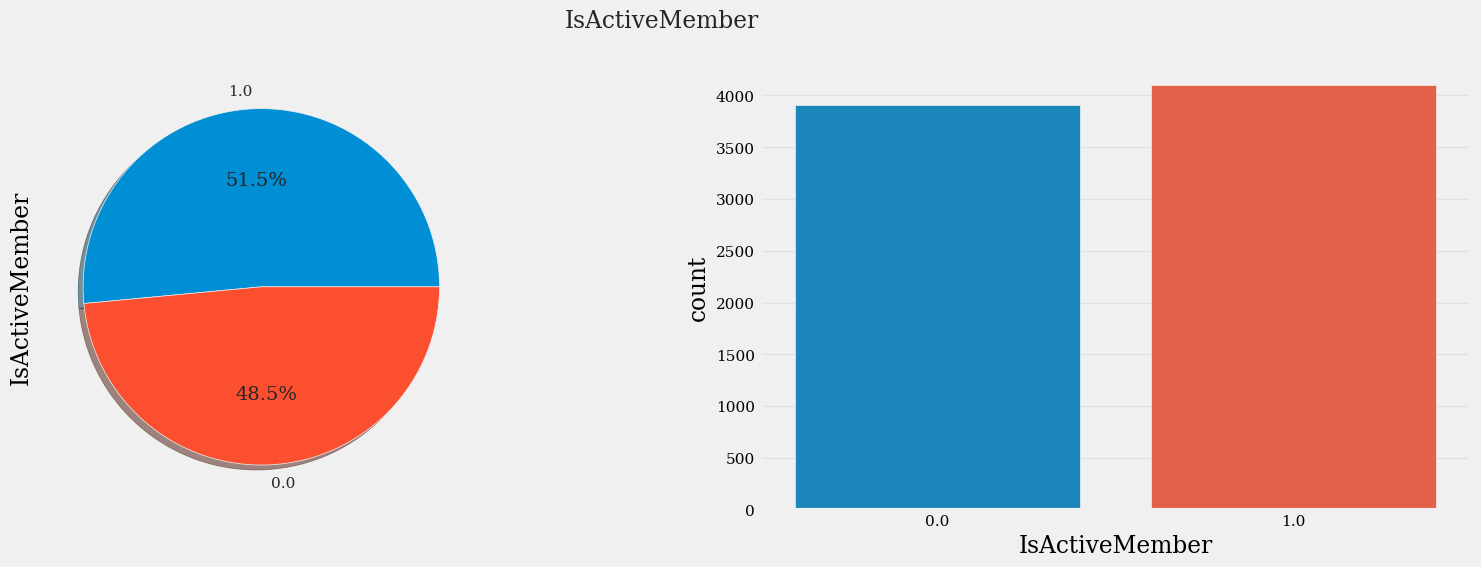

In [13]:
categorical_vars.remove('Exited')

for column in categorical_vars:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    original_data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=training_data,ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

### 2.4 Numerical Value Analysis:

Our Numerical variables are:

- CreditScore
- Age
- Balance
- EstimatedSalary

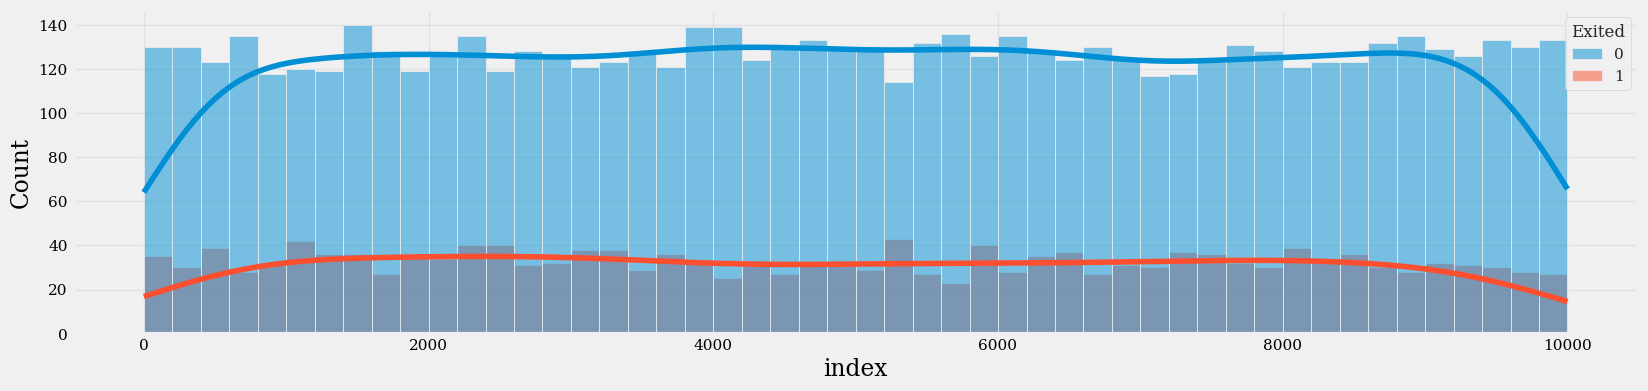

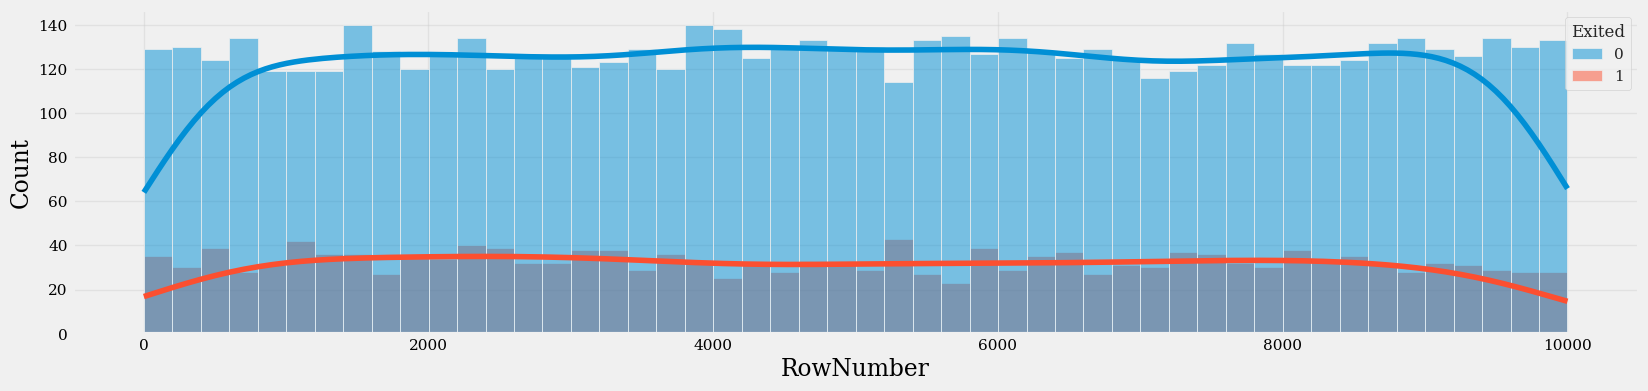

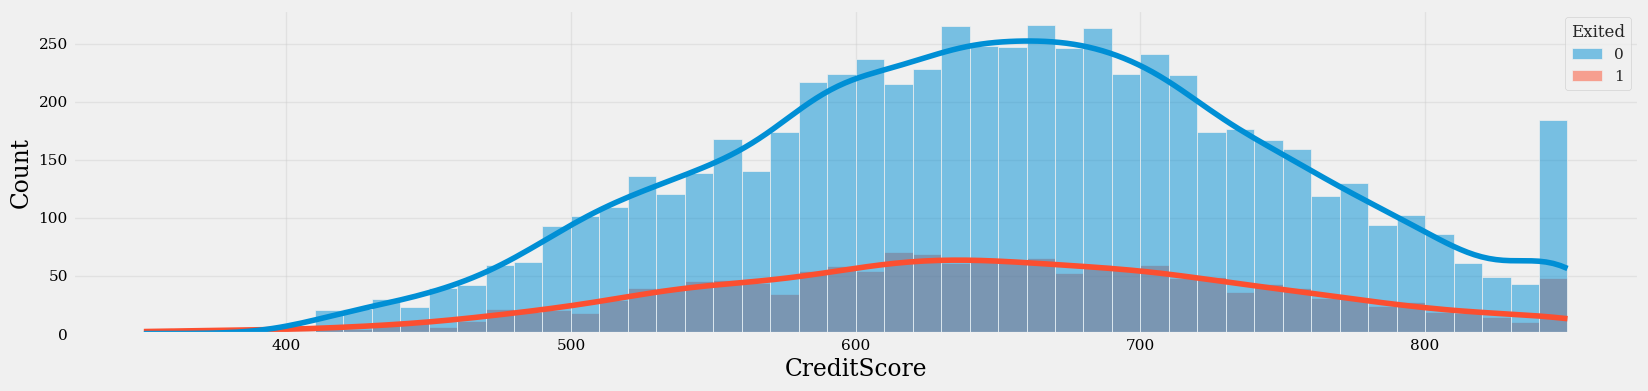

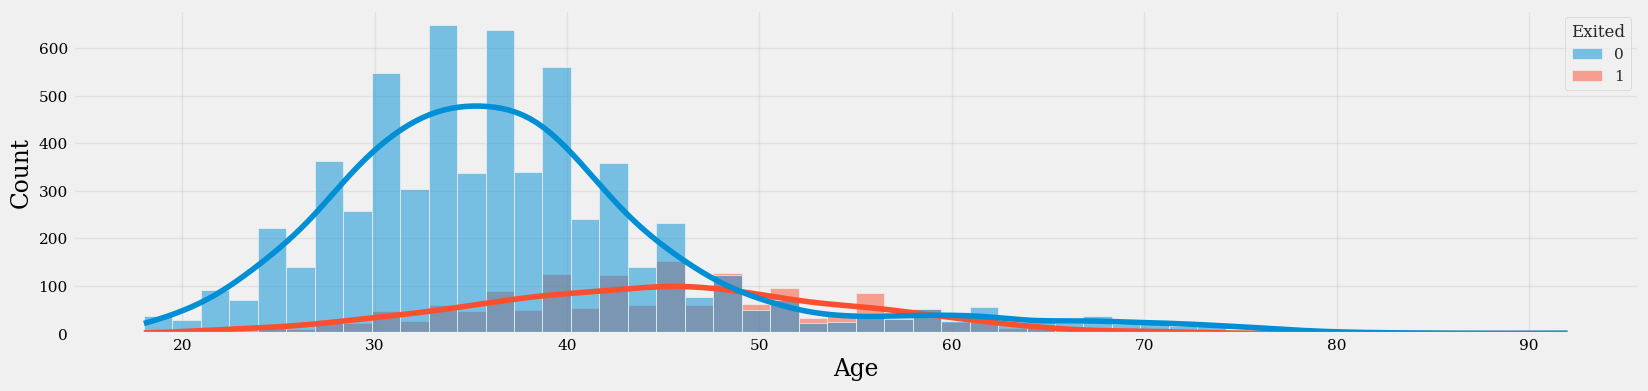

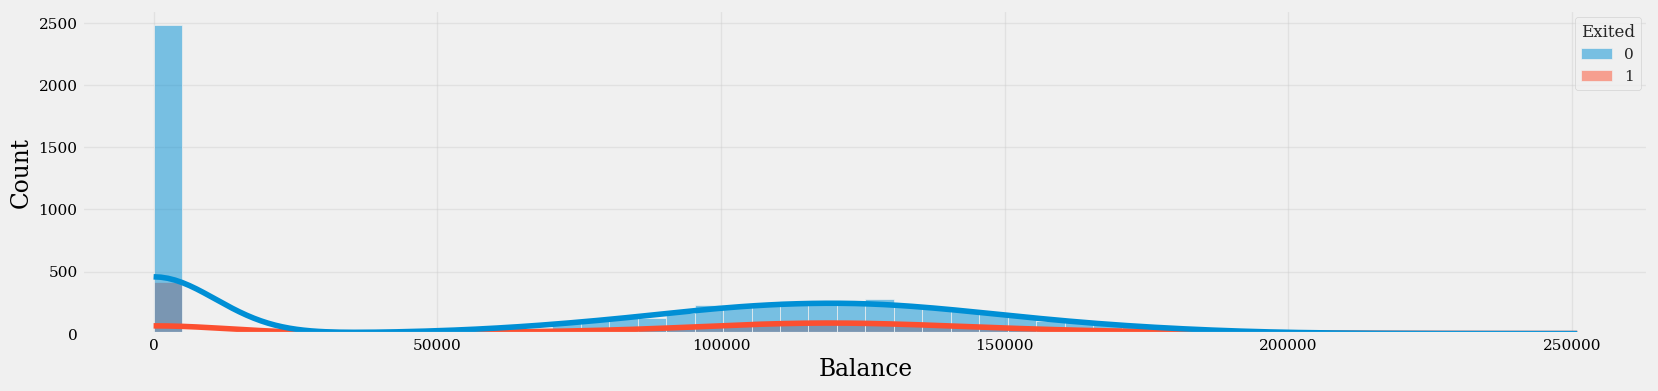

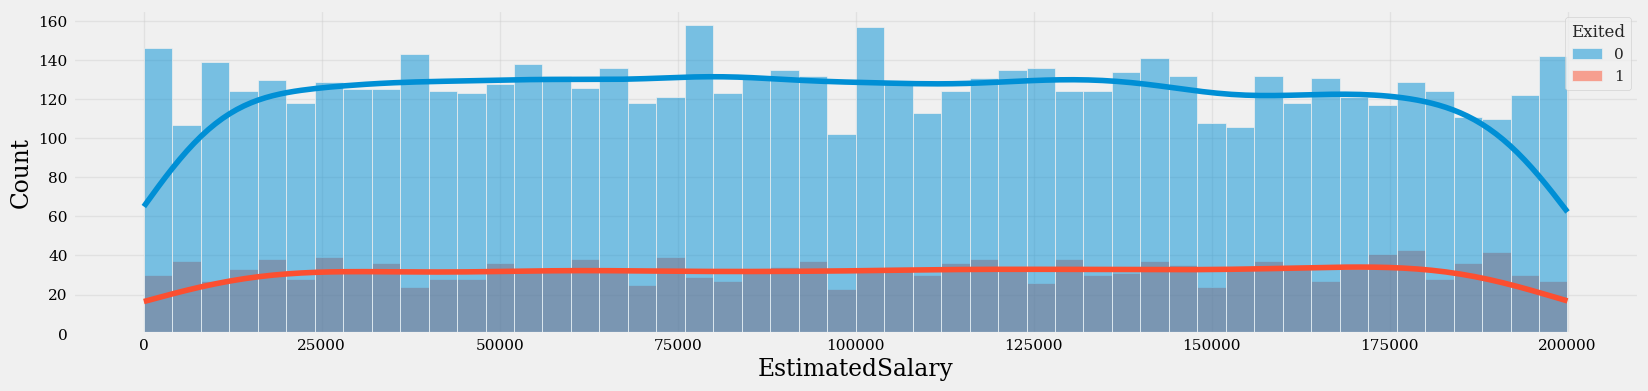

In [14]:
if 'CustomerId' in continuous_vars:
    continuous_vars.remove('CustomerId')

if 'Surname' in continuous_vars:
    continuous_vars.remove('Surname')

for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=training_data, x=column, hue='Exited', bins=50, kde=True)
    plt.show()

### 2.5 Multivariate Analysis:

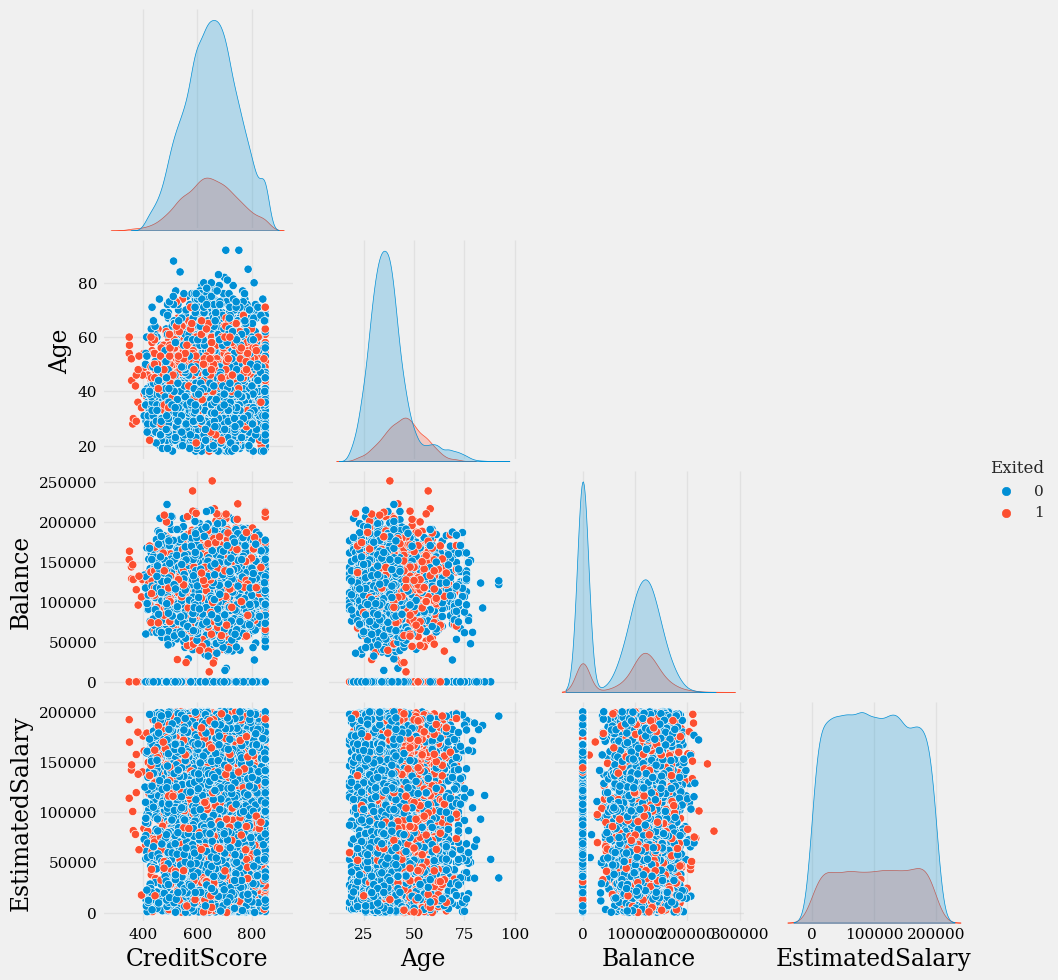

In [15]:
df3 = training_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
sns.pairplot(df3, hue="Exited", corner=True)
plt.show()

### 2.6 Correlation Analysis:


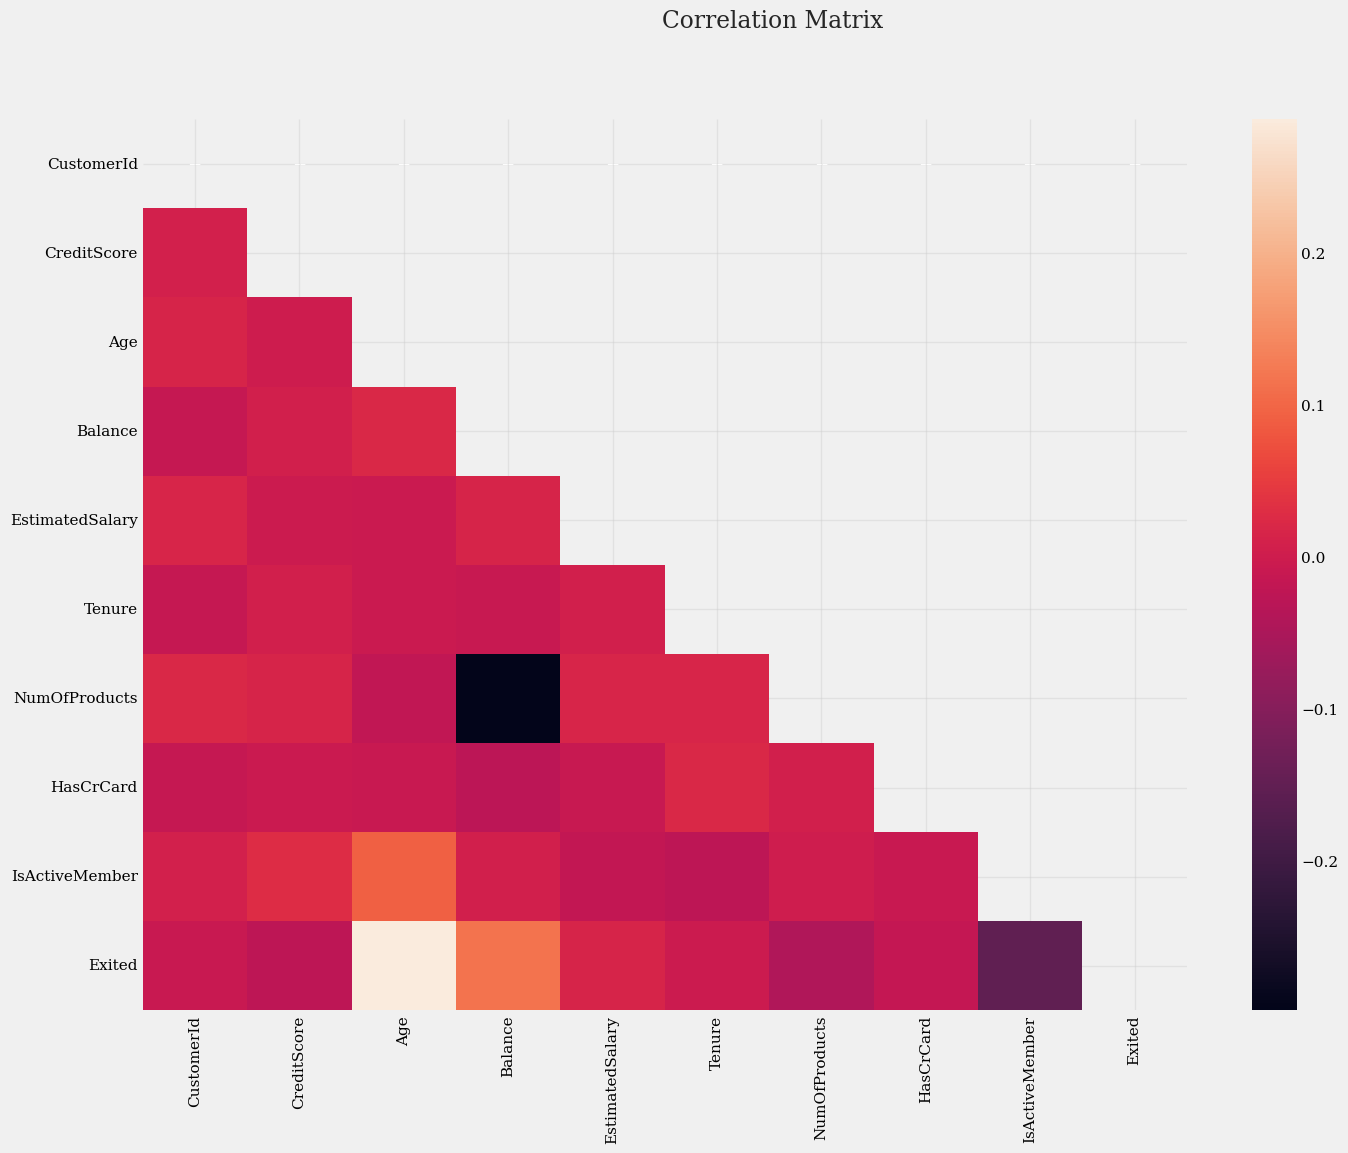

In [16]:
df4 = training_data[[ 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()

corr_matrix=df4.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()

In [17]:
# Note: even though the annote=True, it is not showing the values in the heat map. problem with Seaborn version
print("Seaborn v" + sns.__version__)

Seaborn v0.12.2


### 3. Modelling 

### 3.2 Data Preparation:


In [18]:
X = training_data.drop(['index','RowNumber','CustomerId', 'Surname', 'Exited'], axis=1)
y = training_data['Exited']

In [19]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,807,Spain,Male,42.0,5,0.00,2,1.0,1.0,74900.90
1,623,France,Male,43.0,1,0.00,2,1.0,1.0,146379.30
2,601,Spain,Female,44.0,4,0.00,2,1.0,0.0,58561.31
3,506,Germany,Male,59.0,8,119152.10,2,1.0,1.0,170679.74
4,560,Spain,Female,27.0,7,124995.98,1,1.0,1.0,114669.79


### 3.3 Encoding Categorical Variables:

In [21]:
X_encoded = pd.get_dummies(X, columns=['Geography',
                                       'Gender',
                                       'IsActiveMember',
                                       'HasCrCard',
                                       'NumOfProducts'])

X_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,807,42.0,5,0.00,74900.90,False,False,True,False,True,False,True,False,True,False,True,False,False
1,623,43.0,1,0.00,146379.30,True,False,False,False,True,False,True,False,True,False,True,False,False
2,601,44.0,4,0.00,58561.31,False,False,True,True,False,True,False,False,True,False,True,False,False
3,506,59.0,8,119152.10,170679.74,False,True,False,False,True,False,True,False,True,False,True,False,False
4,560,27.0,7,124995.98,114669.79,False,False,True,True,False,False,True,False,True,True,False,False,False


In [22]:
test_data = testing_data.drop(['index','RowNumber','CustomerId', 'Surname', 'Exited'], axis=1) 
test_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58
1,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10
2,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71
3,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73
4,497,Spain,Male,24.0,3,0.00,2,1.0,0.0,76390.01


In [23]:
X_test_encoded = pd.get_dummies(test_data, columns=['Geography',
                                       'Gender',
                                       'IsActiveMember',
                                       'HasCrCard',
                                       'NumOfProducts'])

X_test_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,608,41.0,1,83807.86,112542.58,False,False,True,True,False,False,True,True,False,True,False,False,False
1,850,43.0,2,125510.82,79084.10,False,False,True,True,False,False,True,False,False,True,False,False,False
2,645,44.0,8,113755.78,149756.71,False,False,True,False,True,True,False,False,True,False,True,False,False
3,684,NaN,2,134603.88,71725.73,True,False,False,False,True,False,True,False,True,True,False,False,False
4,497,24.0,3,0.00,76390.01,False,False,True,False,True,True,False,False,True,False,True,False,False


### 3.4 Splitting Data
- As we discussed earlier both of the classes in our data are highly imbalanced. Almost 80% of our data is from class 0 (not exited) and 20% data is from class 1 (exited). Which also can be analyzed by dividing sum(y) with len(y).

In [ ]:
sum(y) / len(y)

To maintain the equal proportion of the both classes we use stratify. stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y, 
                                                    random_state=42, 
                                                    stratify=y)

In [25]:
sum(y_train) / len(y_train)

0.20463256123979337

In [26]:
sum(y_test) / len(y_test)

0.20439780109945027

As we can see we have both train and test data in equal proportion.

### 3.5 Creating Baseline Model:


In [28]:
clf_xgb_v1 = xgb.XGBClassifier(objective='binary:logistic',
                            # missing=None,
                            seed=42)

clf_xgb_v1.fit(X_train,
            y_train,
            verbose=False,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 3.6 Evaluation


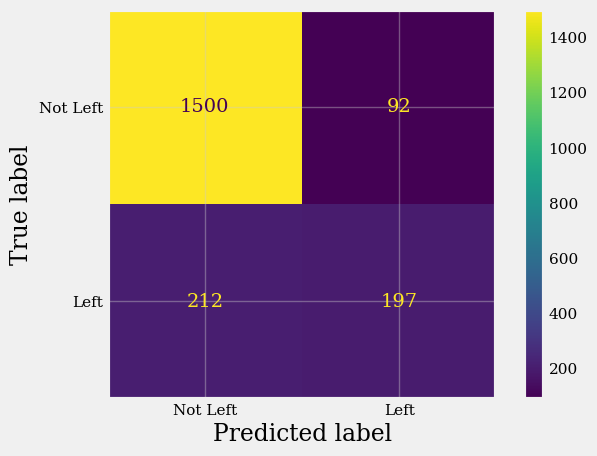

In [29]:
predictions_1 = clf_xgb_v1.predict(X_test)

# sns.set(font_scale=1)
cm = confusion_matrix(y_test, predictions_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

#### Some Observations from above plot:

- from confusion matrix we can see that total of the **1,592** people that **did not leave**, **1,500 (95%)** were correctly classified and from the **409** total people that **left** the company, only **212 (52%)** were correctly classified.

- So we can see that our model is performing very good on `exited=0` and it is performing very poorly on the other class `exited=1`.

- People who are leaving the bank will cost more to the bank so if our model successfully captures more of those people we can say that our model is performing well.


In [41]:
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [1.0, 1.5, 2],
    'reg_lambda': [10.0, 25.0, 50.0],
    'scale_pos_weight': [5, 7, 9]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                early_stopping_rounds=10,
                                eval_metric='auc'),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=1,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X_train,
                       y_train,
                       eval_set=[(X_test, y_test)],
                       verbose=False)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 25.0, 'scale_pos_weight': 7}


In [42]:
print(optimal_parameters.best_params_)

{'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 25.0, 'scale_pos_weight': 7}


### 4.3 Final Model:
Now that we have the best parameter we will create the model out of that.

In [44]:
clf_xgb_v2 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=1.0,
                               learning_rate=0.1,
                               max_depth=5,
                               reg_lambda=10.0,
                               scale_pos_weight=5,
                               subsample=0.9,
                               colsample_bytree=0.5)

clf_xgb_v2.fit(X_train,
               y_train,
               verbose=False,
               early_stopping_rounds=10,
               eval_metric='auc',
               eval_set=[(X_test,y_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

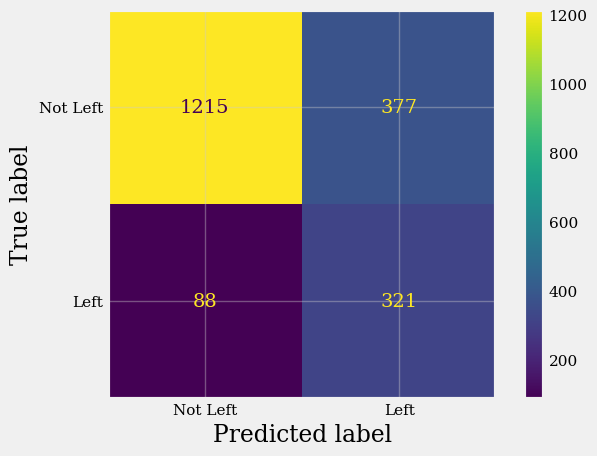

In [45]:
predictions_2 = clf_xgb_v2.predict(X_test)

cm = confusion_matrix(y_test, predictions_2, labels=clf_xgb_v2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

#### Some Observations from above plot:

- From our confusion matrix we can see that from total of **1,592** people that did **not leave** the bank **1,215 (76%)** were correctly classified and out of **409** people that did **leave** the bank, **321 (78%)** were correctly classified.

- Although our accuracy for `Exited=0` is decreasing by some amount but the accracy for the `Exited=1` class is increasing by **29%** which is very huge and we can say that now our model is performing far greater that it was previously

### 5. Visualizations 
#### 5.1 XGBoost Tree


weight:  {'Age': 6.0, 'Balance': 4.0, 'Geography_Spain': 1.0, 'Gender_Female': 1.0, 'IsActiveMember_0.0': 2.0, 'NumOfProducts_1': 4.0, 'NumOfProducts_3': 3.0}
gain:  {'Age': 316.7870178222656, 'Balance': 41.87862777709961, 'Geography_Spain': 16.36688232421875, 'Gender_Female': 27.48486328125, 'IsActiveMember_0.0': 144.0775604248047, 'NumOfProducts_1': 122.80694580078125, 'NumOfProducts_3': 145.97183227539062}
cover:  {'Age': 798.4885864257812, 'Balance': 192.03350830078125, 'Geography_Spain': 267.0379638671875, 'Gender_Female': 310.3547058105469, 'IsActiveMember_0.0': 914.451171875, 'NumOfProducts_1': 484.05242919921875, 'NumOfProducts_3': 501.1781311035156}
total_gain:  {'Age': 1900.7220458984375, 'Balance': 167.51451110839844, 'Geography_Spain': 16.36688232421875, 'Gender_Female': 27.48486328125, 'IsActiveMember_0.0': 288.1551208496094, 'NumOfProducts_1': 491.227783203125, 'NumOfProducts_3': 437.9154968261719}
total_cover:  {'Age': 4790.931640625, 'Balance': 768.134033203125, 'Geogra

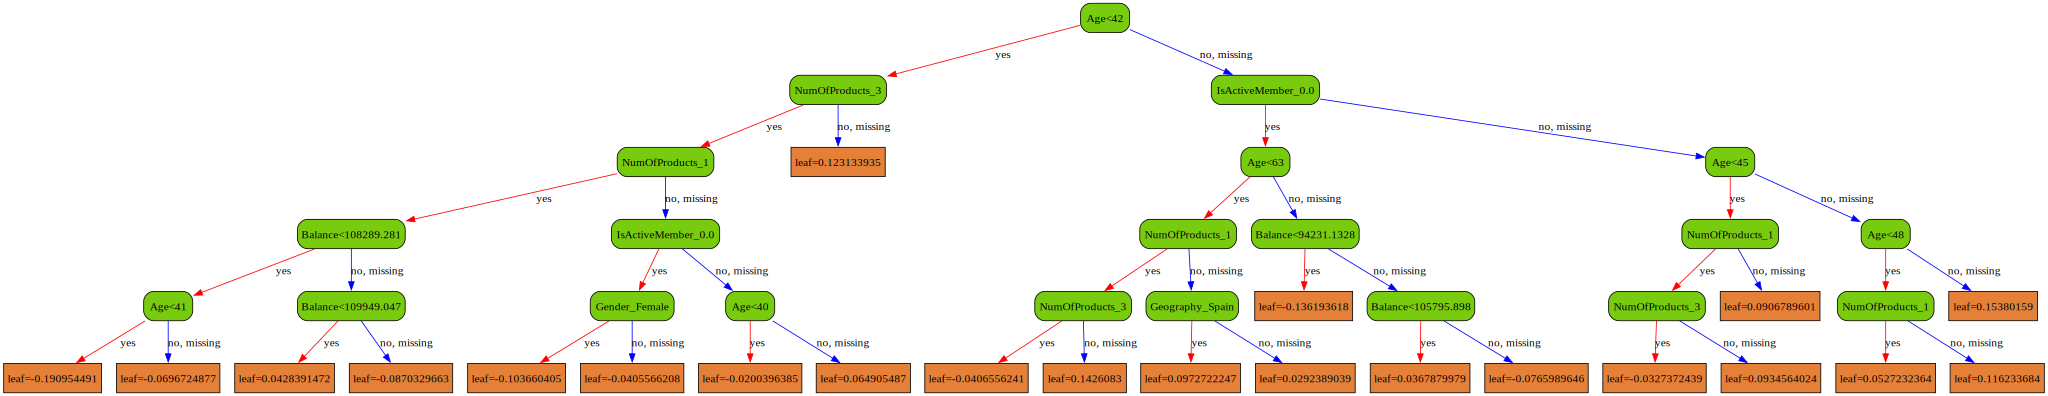

In [46]:
clf_xgb_v3 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=1.0,
                               learning_rate=0.1,
                               max_depth=5,
                               reg_lambda=10.0,
                               scale_pos_weight=5,
                               subsample=0.9,
                               colsample_bytree=0.5,
                               n_estimators=1)

clf_xgb_v3.fit(X_train, y_train)

bst = clf_xgb_v3.get_booster()

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb_v3, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

### 5.2 Feature Importance

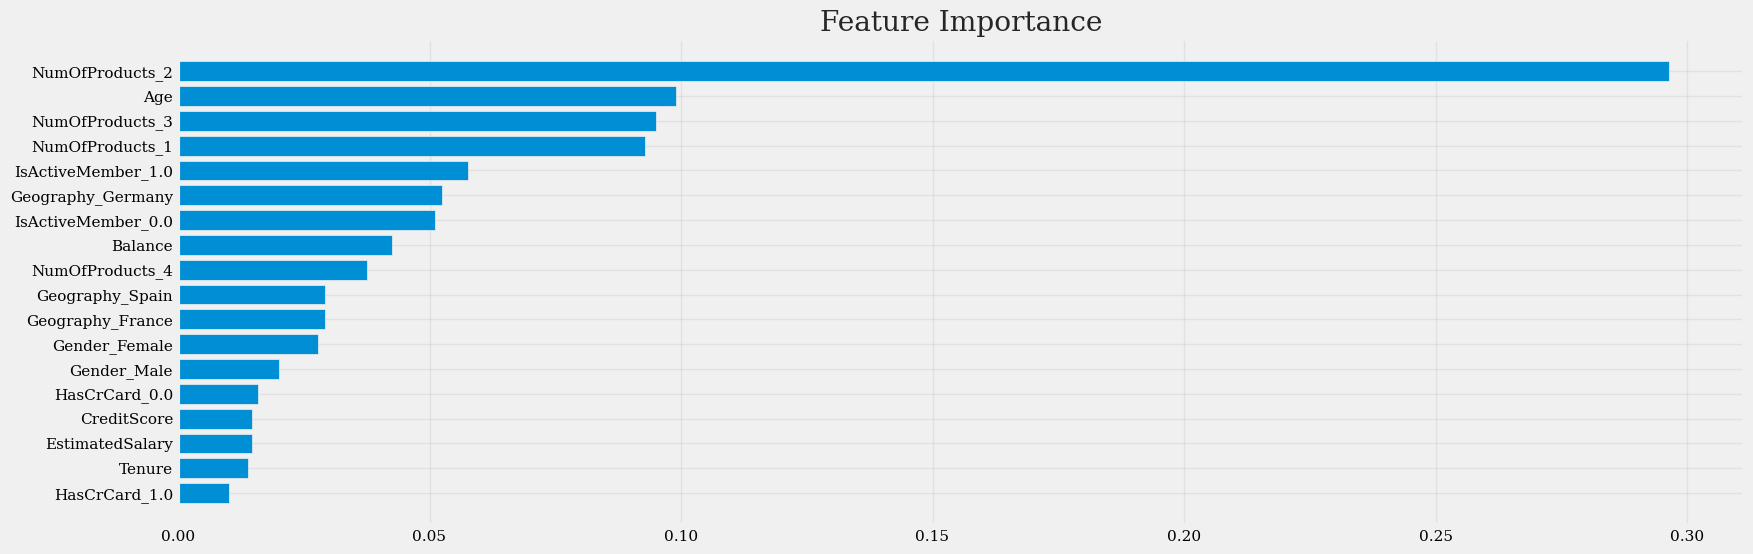

In [47]:
# Tree-based (or Gini) importance

feature_importance = clf_xgb_v2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(18, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()